In [280]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path

In [281]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [437]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [433]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

In [282]:
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [425]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']
    assert(list(sorted(color))==list(color))
    sc = ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                cmap="viridis",
                vmin=0.48,
                vmax=0.75
                   )
    return sc

In [416]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [400]:
# ls /storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode

In [401]:
# results

In [428]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [403]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:34<00:00, 14.24it/s]


In [404]:
# all_results_paths

In [405]:
np.percentile(results_df["avg_test"],99)

nan

In [406]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [407]:
tasks

['global_flow',
 'onset',
 'word_gap',
 'gpt2_surprisal',
 'word_index',
 'word_head_pos',
 'local_flow',
 'face_num',
 'volume',
 'local_flow_angle',
 'speaker',
 'pitch',
 'speech',
 'frame_brightness',
 'word_part_speech',
 'global_flow_angle',
 'delta_pitch',
 'word_length',
 'delta_volume']

In [435]:
# tasks = list(set(results_df.task))
tasks = task_order

In [2]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 25))

num_cols = 3
num_rows = 7
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            ax = fig.add_subplot(outer[19])
            cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.8)
            cbar.set_label("ROC-AUC")
            ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            task = task_order[i*num_cols+j]
            task_df = spatial_avg_results_df.loc[task]
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
#             ax.set_title(task)
            
            if k == 0:
                ax.set_title(task_name_mapping[task], fontsize=24)
                
plt.tight_layout()

NameError: name 'plt' is not defined

In [421]:
merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")


In [1]:
# sorted(list(merged_df.dropna().sort_values(by='avg_test', ascending=True)['avg_test']))

In [412]:
len(tasks)

19

In [413]:
import seaborn as sns



/storage/czw/anaconda3/envs/sss/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


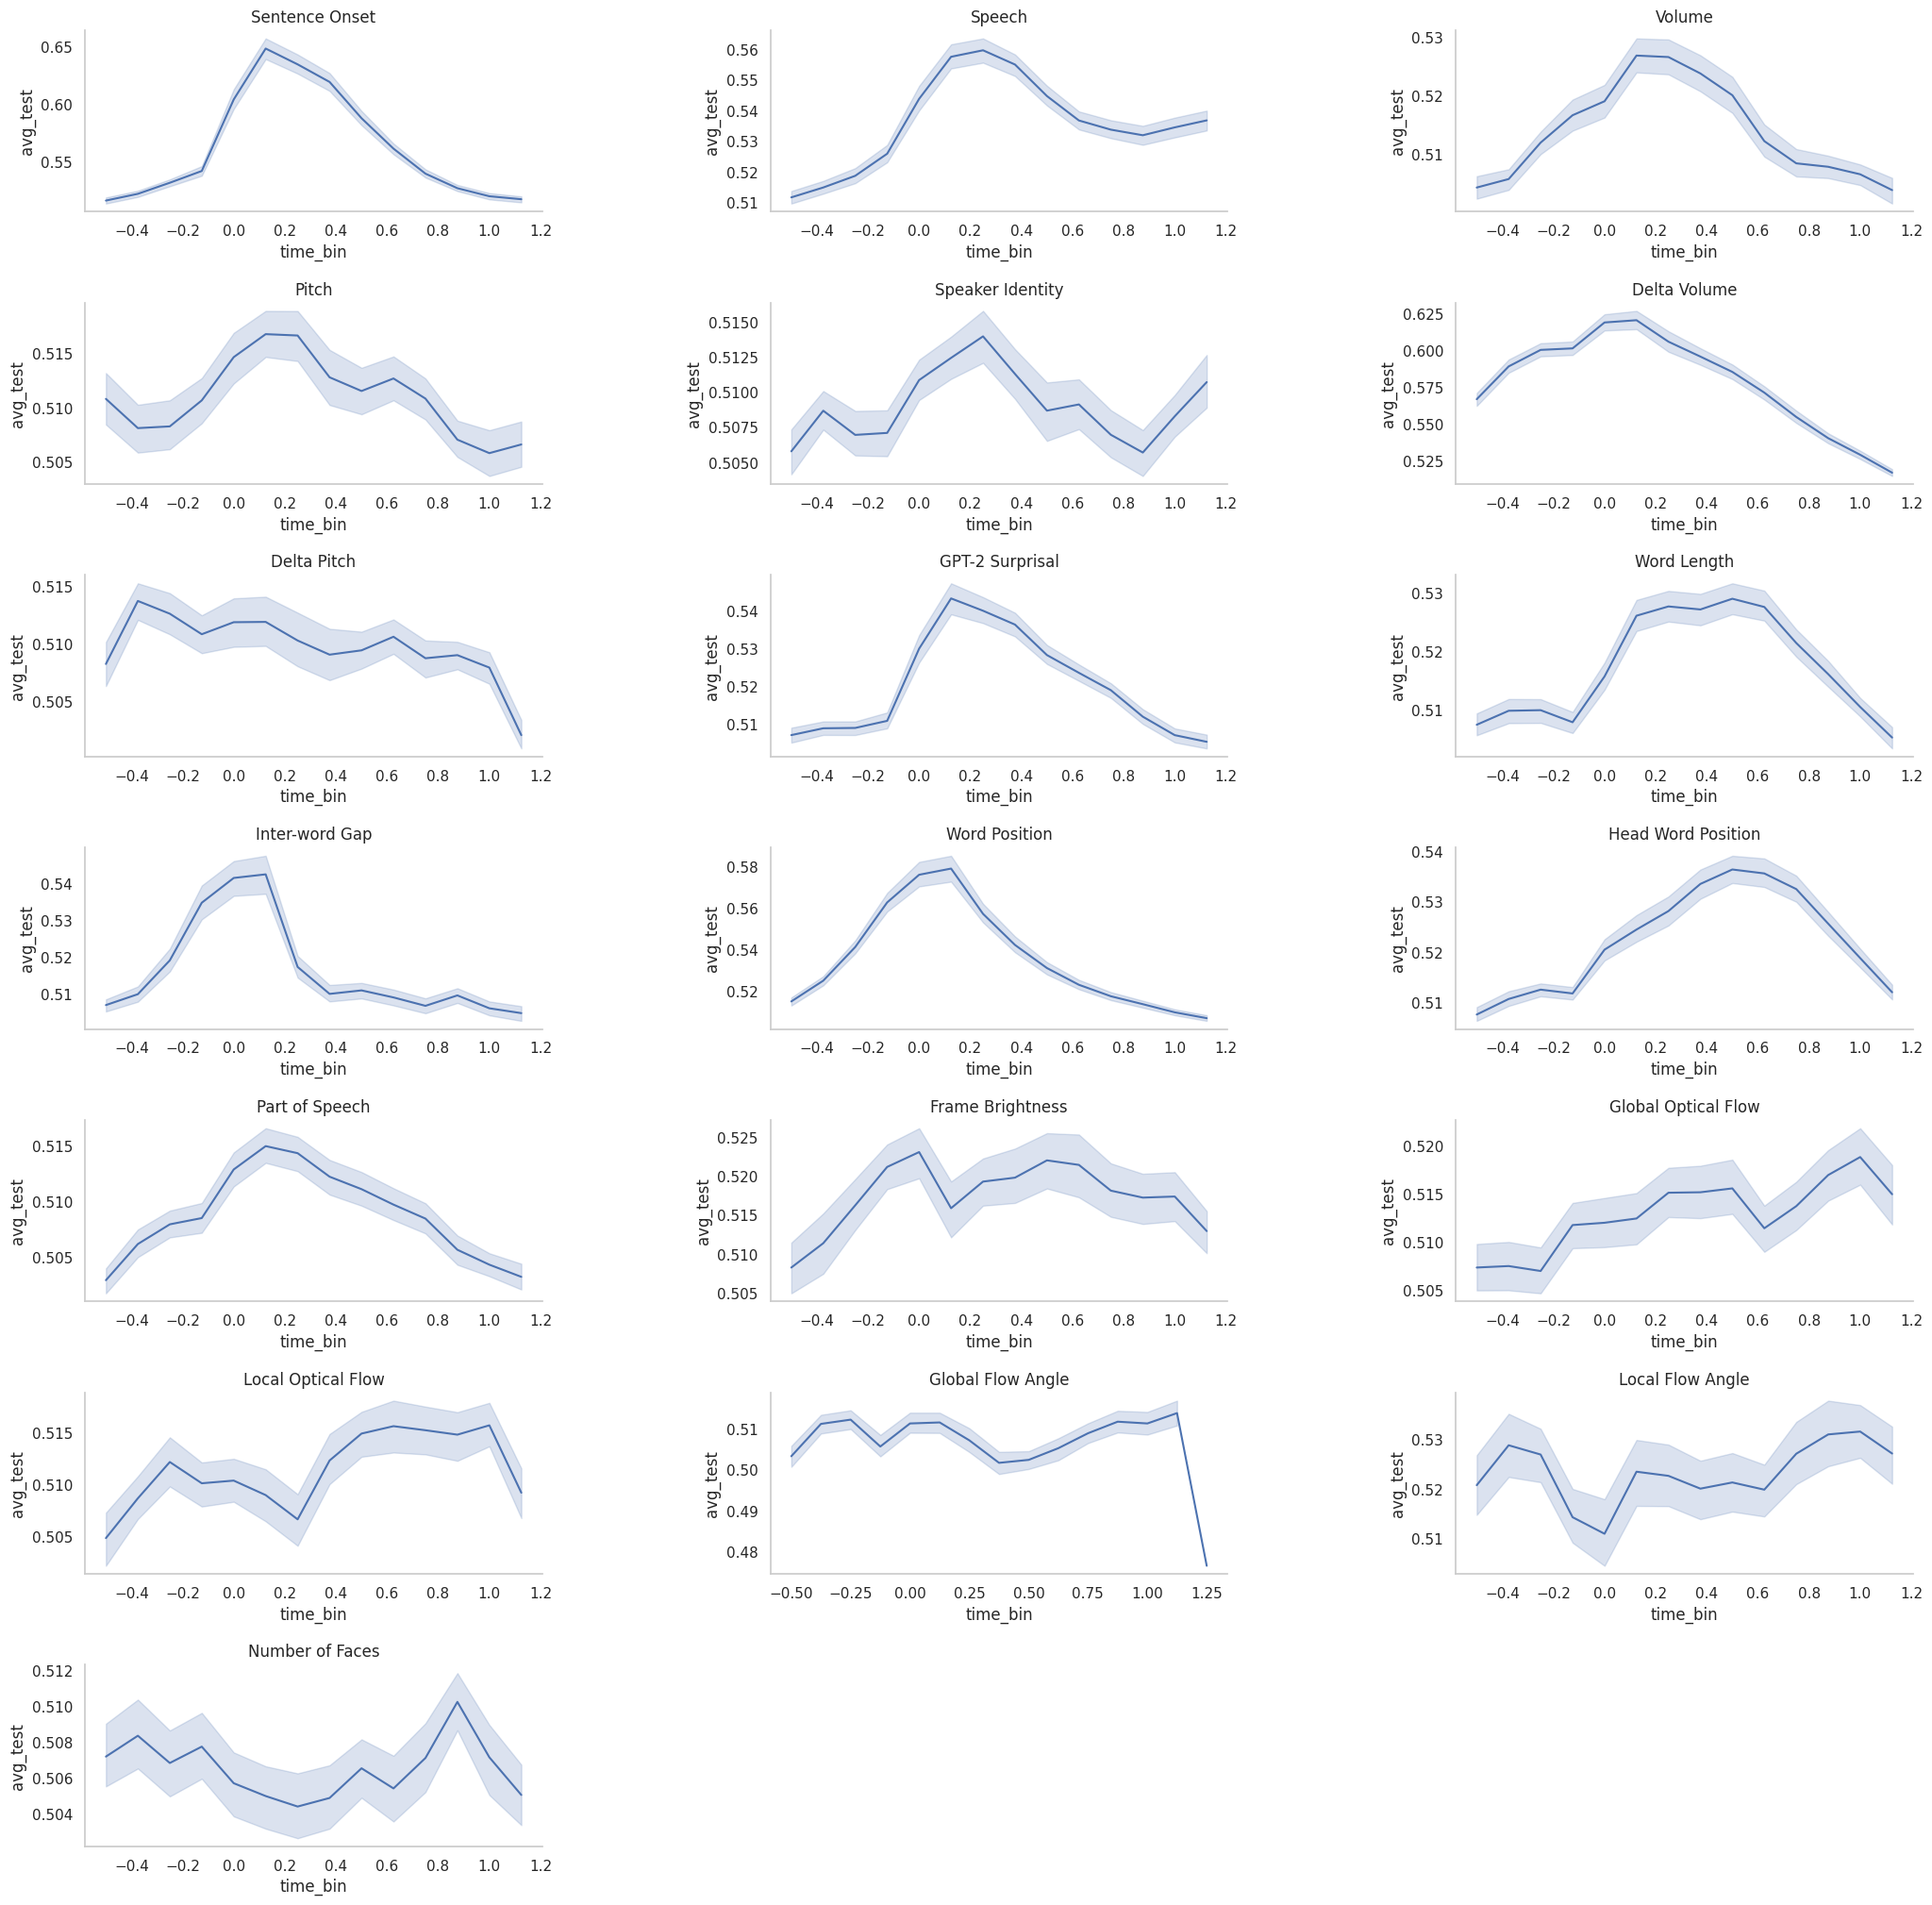

In [494]:
fig = plt.figure(figsize=(25, 25))

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.5, hspace=0.5)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            continue

        ax = fig.add_subplot(outer[outer_idx])
        task = task_order[i*num_cols+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean()
#         good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test").dropna()[-100:].index        
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        sns.lineplot(data=time_df, x="time_bin", y="avg_test")
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task_name_mapping[task])
        sns.despine() 
#         plt.ylim(0.48, 0.70)
plt.tight_layout()

In [490]:
time_df['avg_test']

12670     0.501845
12671     0.517405
12672     0.511778
12673     0.509213
12674     0.505749
            ...   
838403    0.503232
838404    0.497509
838405    0.497870
838406    0.498655
838407    0.505166
Name: avg_test, Length: 1736, dtype: float64

In [491]:
task = "speaker"
good_elecs = results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test").dropna()[-100:].index
# good_elecs = task_df[task_df.avg_test>0.5].index   
# results_df

In [488]:
results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test").dropna()[-100:]

,avg_test,time_bin
ID,,
P2b15-sub_3,0.506962,0.3125
LF3cIc3-sub_7,0.506965,0.3125
F3aOFa5-sub_6,0.506998,0.3125
LF3aOFa14-sub_7,0.507069,0.3125
O1aIb11-sub_3,0.507074,0.3125
...,...,...
F3cOFc14-sub_6,0.512555,0.3125
F2eIc8-sub_6,0.512566,0.3125
T3bOT1-sub_1,0.513654,0.3125


In [455]:
# results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
# results_df[(results_df.task==task)]
task

'speaker'

In [459]:
'speaker' in set(results_df.task)

True

In [471]:
task_df = results_df[results_df.task=="speaker"]
# task_df[task_df.isnull().any(axis=1)]
task_df.dropna()

,subject,trial,ID,electrode,avg_test,time_bin,task
203434,2,2,LT3a1-sub_2,LT3a1,0.488910,-0.500,speaker
203435,2,2,LT3a1-sub_2,LT3a1,0.492343,-0.375,speaker
203436,2,2,LT3a1-sub_2,LT3a1,0.494262,-0.250,speaker
203437,2,2,LT3a1-sub_2,LT3a1,0.498331,-0.125,speaker
203438,2,2,LT3a1-sub_2,LT3a1,0.497798,0.000,speaker
...,...,...,...,...,...,...,...
898813,1,0,T2d6-sub_1,T2d6,0.515533,0.625,speaker
898814,1,0,T2d6-sub_1,T2d6,0.488354,0.750,speaker
898815,1,0,T2d6-sub_1,T2d6,0.499355,0.875,speaker
898816,1,0,T2d6-sub_1,T2d6,0.498609,1.000,speaker


In [ ]:
task_df[task_df.avg_test>0.5].index

In [ ]:
results_df

In [ ]:
all_localization_dfs = []
braintreebank_root = "/storage/czw/braintreebank_data/"
for fpath in glob(os.path.join(braintreebank_root, "localization/sub_*/depth-wm.csv")):
    sub_localization_df = pd.read_csv(fpath)
    sub_localization_df["Subject"] = subject = os.path.dirname(fpath).split("/")[-1]
    all_localization_dfs.append(sub_localization_df)
all_localization_df = pd.concat(all_localization_dfs)

all_localization_df["region_common_name"] = [dk2region(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["common_name"] = [dk2text(x) for x in all_localization_df.DesikanKilliany]

In [ ]:
# all_localization_dfs = {}
subject

In [ ]:
all_localization_df["ID"] = all_localization_df.Electrode + "-" + all_localization_df.Subject

In [ ]:
localization_merged_df = pd.merge(results_df, all_localization_df, on="ID", how="left")

In [ ]:
localization_merged_df

In [ ]:
#https://bookdown.org/u0243256/tbicc/freesurfer.html
dk2text_d = {'supramarginal': 'supramarginal',
             'postcentral': 'postcentral',
             'medialorbitofrontal': 'medial orbitofrontal',
             'caudalmiddlefrontal': 'caudal middle frontal',
             'posteriorcingulate': 'posterior cingulate',
             'middletemporal': 'middle temporal',
             'superiortemporal': 'superior temporal',
             'bankssts': 'Banks of sup. temp. sul.',
             'superiorparietal': 'superior parietal',
             'precuneus': 'precuneus',
             'entorhinal': 'entorhinal',
             'parstriangularis': 'pars triangularis',
             'precentral': 'precentral',
             'parsorbitalis': 'pars orbitalis',
             'insula': 'insula',
             'parahippocampal': 'parahippocampal',
             'inferiortemporal': 'inferior temporal',
             'parsopercularis': 'pars opercularis',
             'fusiform': 'fusiform',
             'transversetemporal': 'transverse temporal',
             'superiorfrontal': 'superior frontal',
             'paracentral': 'paracentral',
             'lateralorbitofrontal': 'lateral orbitofrontal',
             'caudalanteriorcingulate': 'caudal anterior cingulate',
             'inferiorparietal': 'inferior parietal',
             'rostralanteriorcingulate': 'rostral anterior cingulate',
             'isthmuscingulate': 'isthmus cingulate',
             'temporalpole': 'temporal pole',
             'rostralmiddlefrontal': 'rostral middle frontal',
             'amygdala': 'Amygdala',
             'hippocampus': 'Hippocampus',
             'inf-lat-vent': 'inferior lateral ventrical',
             'putamen': 'putamen',
             'unknown': 'unknown'}

dk_names = ["superior frontal", "rostral middle frontal", "caudal middle frontal", "pars opercularis",
           "pars triangularis", "pars orbitalis", "lateral orbitofrontal", "medial orbitofrontal",
           "precentral", "paracentral", "frontal pole", "superior parietal", "inferior parietal",
           "supramarginal", "postcentral", "precuneus", "superior temporal", "middle temporal",
           "inferior temporal", "bankssts", "fusiform", "transverse temporal",
           "entorhinal","temporal pole", "parahippocampal", "lateral occipital", "lingual", "cuneus",
           "pericalcarine","rostral anterior cingulate", "caudal anterior cingulate",
           "posterior cingulate","isthmus cingulate", "insula"]

region_ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6]
name2region_id = {n:x for x,n in zip(region_ids, dk_names)}
region_id2region_name = {x+1:n for x,n in enumerate(["Frontal", "Parietal", "Temporal", "Occipital", "Cingulate", "Insula"])}

def dk2text(label):
    l = label.replace('ctx-','')
    l = l.replace('rh-','')
    l = l.replace('lh-','')
    l = l.replace('Left-','')
    l = l.replace('Right-','')
    l = l.lower()
    return dk2text_d[l]

def dk2region(label):
    dk_name = dk2text(label)
    if dk_name in name2region_id:
        return region_id2region_name[name2region_id[dk_name]]
    return dk_name

In [ ]:
data = localization_merged_df.groupby('common_name').mean()[["avg_test"]]
data = data[~(data.index=="unknown")]
data = data.sort_values(by="avg_test")
data = data.reset_index()
data.common_name = [x.capitalize() for x in data.common_name]
f = plt.figure(figsize=[5,9])

order = data.index
# sns.barplot(data=data, x="common_name", y="onset_sig", color="grey")
sns.barplot(data=data, y="common_name", x="avg_test", color="white", edgecolor="black")
sns.despine()

plt.tick_params(labelsize=25)
plt.ylabel("")
plt.xlabel("Percent of electrodes", size=20)
plt.figure(dpi=900)

In [ ]:
data

# compare results